# Inspector

In [1]:
def disp(df):
    """
    Pretty print Pandas dataframe in Jupyter notebook cell, only show first 10 and last 10 rows.
    Note: this is not required, and only used for aesthetic purposes in the docs page as the native
    output is pretty ugly.
    """
    try:
        return print(df.to_string(max_rows=20))
    except Exception as e:
        print(df)

---
## Preparation

The `Inspector` class searches for ASDFDataSets to aggregate data from. These datasets are usually created during a seismic inversion. For example, running SeisFlows3 + Pyaflowa will generate datasets at each evaluation of the misfit function (!!! Add link to this page). For this short example, we will manually fill a dataset to illustrate the `Inspector` initialization routine.

In [2]:
import os
import obspy
from pyasdf import ASDFDataSet
from pyatoa import Config, Manager, Inspector, logger
logger.setLevel("INFO")

In [3]:
# This code block initiates an ASDFDataSet with waveform and metadata, to illustrate 
# the Inspector. First read in test waveform data and metadata
inv = obspy.read_inventory("../tests/test_data/test_dataless_NZ_BFZ.xml")
cat = obspy.read_events("../tests/test_data/test_catalog_2018p130600.xml")
event = cat[0]
st_obs = obspy.read("../tests/test_data/test_obs_data_NZ_BFZ_2018p130600.ascii")
st_syn = obspy.read("../tests/test_data/test_syn_data_NZ_BFZ_2018p130600.ascii")

# The Manager class can fill up a dataset with the write() function. Processing results
# accumulated during the flow() function automatically write to the dataset.
ds_fid = "../tests/test_data/docs_data/inspector_doc/docs_ASDFDataSet.h5"

if os.path.exists(ds_fid):
    os.remove(ds_fid)
    
with ASDFDataSet(ds_fid) as ds:
    cfg = Config(iteration=1, step_count=0)
    mgmt = Manager(ds=ds, config=cfg, inv=inv, event=event, st_obs=st_obs, st_syn=st_syn)
    mgmt.write()
    mgmt.flow()

[2022-02-24 12:12:52] - pyatoa - INFO: standardizing streams
[2022-02-24 12:12:52] - pyatoa - INFO: preprocessing observation data
[2022-02-24 12:12:52] - pyatoa - INFO: adjusting taper to cover time offset -20.0
[2022-02-24 12:12:52] - pyatoa - INFO: preprocessing synthetic data
[2022-02-24 12:12:52] - pyatoa - INFO: adjusting taper to cover time offset -20.0
[2022-02-24 12:12:52] - pyatoa - INFO: running Pyflex w/ map: default
[2022-02-24 12:12:52] - pyatoa - INFO: 1 window(s) selected for comp E
[2022-02-24 12:12:52] - pyatoa - INFO: 1 window(s) selected for comp N
[2022-02-24 12:12:52] - pyatoa - INFO: 1 window(s) selected for comp Z
[2022-02-24 12:12:52] - pyatoa - INFO: 3 window(s) total found
[2022-02-24 12:12:52] - pyatoa - INFO: 0.365 misfit for comp E
[2022-02-24 12:12:52] - pyatoa - INFO: 1.620 misfit for comp N
[2022-02-24 12:12:52] - pyatoa - INFO: 0.004 misfit for comp Z
[2022-02-24 12:12:52] - pyatoa - INFO: total misfit 1.989


---
## Initializing and data discovery

The `Inspector` class will automatically search for data with the `discover` function. An optional `tag` is used for output filenames. If `tag` is not set, the tag will use the name `default`. 

During data discovery function, the `Inspector` retrieves source and receiver metadata, misfit windows information (e.g., starttimes, time shifts, amplitude anomalies etc.), adjoint source information (e.g., total misfit). 

These data are stored in a Pandas dataframe and uniquely labelled by keyword (e.g., iteration, event id, station name, component) so that they are easily accessible.

In [4]:
# Initialize the Inspector and discover all available datasets (of which there is only 1)
insp = Inspector(tag="default", verbose=True)
insp.discover(path="../tests/test_data/docs_data/inspector_doc")
# Remove dataset from test data to avoid large fileset in the repo
os.remove(ds_fid)
print(insp)

docs_ASDFDataSet.h5       001/001...done
1    event(s)
1    station(s)
1    iteration(s)
1    evaluation(s)


## Accessing data within the Inspector

Let's see how we can access the information that was collected during the data discover phase. 
There are two main categories here: metadata and measurement data


### Source and receiver metadata

A list of event ids and station names can be accessed through the `events` and `stations` attributes, respectfully. Metadata, including locations and source information like magnitude and origint time are accesible through the `sources` and `receivers` attributes. The `srcrcv` attribute provides information relating to each source-receiver pair.

In [5]:
# The `events` attributes simply lists all event ids (pulled from QuakeML resource IDs)
disp(insp.events)

['2018p130600']


In [6]:
# The `stations` attributes lists receiver names (without network codes)
disp(insp.stations)

['BFZ']


In [7]:
# `sources` provides more detailed event information, including origin time, hypocentral location, and magnitude.
disp(insp.sources)

                                    time  magnitude   depth_km   latitude   longitude
event_id                                                                             
2018p130600  2018-02-18T07:43:48.127644Z   5.156706  20.594599 -39.948975  176.299515


In [8]:
# `receivers` provides more detailed station information, with network code and location
disp(insp.receivers)

                  latitude   longitude
network station                       
NZ      BFZ     -40.679647  176.246245


In [9]:
# The `srcrcv` attribute provides information relating to source-receiver pairs
# including epicentral distance and backazimuth. Each pair will get a row in this dataframe.
disp(insp.srcrcv)

         event network station  distance_km  backazimuth
0  2018p130600      NZ     BFZ    81.260637     3.211526


---
### Measurement data from misfit windows

During an inversion, Pyatoa (via Pyflex and Pyadjoint) collects information from each misfit window and adjoint source. The Inspector aggregates and labels all this information within a Pandas dataframe so that it is easily accesible. Information is stored in the `windows` attribute. 

Each row in the `window` attribute corresponds to a single misfit window, which in turn is related to a component, station, event, and iteration. Since the `windows` attribute is simply a Pandas dataframe, all standard Pandas operations can be used to access data.

In [10]:
disp(insp.windows)

         event iteration step network station channel component    misfit  length_s      dlnA  window_weight  max_cc_value  relative_endtime  relative_starttime  cc_shift_in_seconds           absolute_starttime             absolute_endtime
0  2018p130600       i01  s00      NZ     BFZ     HHE         E  0.365397     62.76 -0.709653       5.469764      0.871537             77.07               14.31                 1.08  2018-02-18T07:43:42.437644Z  2018-02-18T07:44:45.197644Z
1  2018p130600       i01  s00      NZ     BFZ     HHN         N  1.620000     39.15 -0.828518       3.882748      0.991762             77.07               37.92                 1.89  2018-02-18T07:44:06.047644Z  2018-02-18T07:44:45.197644Z
2  2018p130600       i01  s00      NZ     BFZ     HHZ         Z  0.004050     21.21 -0.903363       2.101535      0.990823             41.46               20.25                 0.00  2018-02-18T07:43:48.377644Z  2018-02-18T07:44:09.587644Z


In [11]:
# Rows in the `windows` dataframe are accessible via array indexing
insp.windows.iloc[0]

event                                  2018p130600
iteration                                      i01
step                                           s00
network                                         NZ
station                                        BFZ
channel                                        HHE
component                                        E
misfit                                    0.365397
length_s                                     62.76
dlnA                                     -0.709653
window_weight                             5.469764
max_cc_value                              0.871537
relative_endtime                             77.07
relative_starttime                           14.31
cc_shift_in_seconds                           1.08
absolute_starttime     2018-02-18T07:43:42.437644Z
absolute_endtime       2018-02-18T07:44:45.197644Z
Name: 0, dtype: object

In [12]:
# Each of these series can in turn be queried for specific attributes
insp.windows.iloc[0].absolute_starttime

'2018-02-18T07:43:42.437644Z'

In [13]:
# The User can query a single column, e.g., to get all cc values in a list. Pandas is great:)
insp.windows["max_cc_value"]

0    0.871537
1    0.991762
2    0.990823
Name: max_cc_value, dtype: float64

In [14]:
# Which in turn can be operated on like numpy arrays (or Pandas series)
insp.windows["max_cc_value"].mean()

0.95137376274536101

---
### Misfits and window number

The `Inspector` has some useful functions for calculating the misfit (`misfit`) for various levels (per function evaluation, per station, per event) and the number of misfit windows (`nwin`) for various levels. These functions are useful for looking at larger-scale changes within the inversion, e.g., when creating convergence plots showing misfit reduction per iteration, or for understanding how a new set of parameters affected the total amount of the dataset measured.

### Misfits

The equations for misfit for a single earthquake and for a single iteration are defined by Equations 6 and 7, respectively from [Tape et al., (2010)](https://academic.oup.com/gji/article/180/1/433/600143). These are automatically calculated by the Inspector when you call the `misfit` function. The resulting dataframe rows are given for each line search step within an iteration. 

In [15]:
# Note: The summed_misfit and misfit are the same here because we only have 1 event
# misfit = summed_misfit / n_event
disp(insp.misfit())

                n_event  summed_misfit    misfit
iteration step                                  
i01       s00         1       0.331575  0.331575


In [16]:
# We can change the level to look at a per-event misfit. Misfit is scaled by the number of windows per event
disp(insp.misfit(level="event"))

                            unscaled_misfit  nwin    misfit
iteration step event                                       
i01       s00  2018p130600         1.989447     3  0.331575


In [17]:
# We can also look at a per-station misfit
disp(insp.misfit(level="station"))

                                    unscaled_misfit  nwin    misfit
iteration step event       station                                 
i01       s00  2018p130600 BFZ             1.989447     3  0.663149


---
### Number of Windows

It is usually useful to know the number of measurement windows you have, useful as a proxy for how good your data is, or how well-suited your windowing parameters are for a given dataset. This information is accessible through the `nwin` function. As with the `misfit` function, the User can select the level at which they want this information.

I have also found it useful to look at the cumulative window length (`length_s`). The reasoning behind this is that as one looks at shorter periods (higher frequencies), window lengths become shorter to accomdate higher-frequency phases. In other words, one long window can be chopped into many smaller windows, while still covering the same section of the waveform. `length_s` therefore provides another value that can be compared between iterations.

In [18]:
# `nwin` will return both the number of windows, and the cumulative window length
disp(insp.nwin())

                nwin  length_s
iteration step                
i01       s00      3    123.12


In [19]:
# Again, we can make choices about the level at which we want this information
disp(insp.nwin(level="event"))

                            nwin  length_s
iteration step event                      
i01       s00  2018p130600     3    123.12


In [20]:
# These values are the same because we only have one source-receiver pair
disp(insp.nwin(level="station"))

                        nwin  length_s
iteration step station                
i01       s00  BFZ         3    123.12


---
## Data accessing functions

Using Pandas syntax, the User should be able to get at any permutation of data that they want to analyze. However, I was personally tired of constantly looking up syntax for common operations such as isolating windows for only a certain event. The Inspector therefore has a few built-in functions which wrap over some commonly required data manipulation routines. These functions include: 

* `isolate`: Use keywords to isolate specific keywords from the `windows` attribute
* `stats`: Calculate per-level stastical values within the `windows` attribute
* `minmax`: Print out min and max values for each parameter in the `windows` attribute
* `compare`: Comapre misfit and windows on an event by event basis between two evaluations.
* `compare_windows`: Compare individual misfit windows between two evaluations.

In order to illustrate the functionality behind these accessing functions, we'll use an Inspector that has already been filled out with multiple iterations of data.

In [21]:
insp = Inspector()
# We explicitely call the `read` function to access an Inspector that we already created
insp.read(path="../tests/test_data", tag="test_inspector")
insp

2    event(s)
34   station(s)
1    iteration(s)
4    evaluation(s)

In [22]:
# Let's just take a look at this Inspector with tools we covered above
disp(insp.srcrcv)

          event network station  distance_km  backazimuth
0   2014p952799      NZ     BFZ   308.576683    29.701984
1   2014p952799      NZ     BKZ   165.256199    52.610982
2   2014p952799      NZ    ETVZ   221.435082    64.421412
3   2014p952799      NZ    FWVZ   239.506726    63.067781
4   2014p952799      NZ     HAZ    58.051017   161.539674
5   2014p952799      NZ     HIZ   275.598114    84.943166
6   2014p952799      NZ    KHEZ   364.513282    72.749562
7   2014p952799      NZ     KHZ   597.315496    40.763237
8   2014p952799      NZ     KNZ    89.847983    18.102357
9   2014p952799      NZ    MAVZ   239.494856    62.674003
..          ...     ...     ...          ...          ...
58  2013p617227      NZ     TOZ   461.054429   195.046485
59  2013p617227      NZ    TRVZ   298.058028   204.468872
60  2013p617227      NZ     TSZ   245.159903   220.071360
61  2013p617227      NZ     URZ   465.140442   213.035005
62  2013p617227      NZ     VRZ   295.554657   191.271870
63  2013p61722

In [23]:
disp(insp.nwin())

                nwin    length_s
iteration step                  
i01       s00    206  14760.4200
          s01    204  14682.1200
          s02    207  14612.4475
          s03     97   7265.7325


In [24]:
disp(insp.windows)

           event iteration step network station channel component     misfit  length_s      dlnA  window_weight  max_cc_value  relative_endtime  relative_starttime  cc_shift_in_seconds           absolute_starttime             absolute_endtime
0    2014p952799       i01  s00      NZ     BFZ     BXE         E  31.100561   86.5650  0.657158       7.951721      0.918584          133.4000             46.8350               8.3375  2014-12-19T12:51:49.315000Z  2014-12-19T12:53:15.880000Z
1    2014p952799       i01  s00      NZ     BFZ     BXN         N  36.594012  102.2975 -0.177826       9.256127      0.904824          129.6300             27.3325               8.5550  2014-12-19T12:51:29.812500Z  2014-12-19T12:53:12.110000Z
2    2014p952799       i01  s00      NZ     BFZ     BXZ         Z  27.343013   97.7300  0.202383       8.988358      0.919713          129.6300             31.9000               7.3950  2014-12-19T12:51:34.380000Z  2014-12-19T12:53:12.110000Z
3    2014p952799       i01  

---
### Selecting data using Inspector.isolate()

Arguably one of the more useful accessing functions, `isolate` allows the User to traverse through the Dataframe by keyword, or combination of keywords.

In [25]:
# The `isolate` function allows us to pick out very specific keywords from our `windows`
disp(insp.isolate(event="2014p952799"))

           event iteration step network station channel component     misfit  length_s      dlnA  window_weight  max_cc_value  relative_endtime  relative_starttime  cc_shift_in_seconds           absolute_starttime             absolute_endtime
0    2014p952799       i01  s00      NZ     BFZ     BXE         E  31.100561   86.5650  0.657158       7.951721      0.918584          133.4000             46.8350               8.3375  2014-12-19T12:51:49.315000Z  2014-12-19T12:53:15.880000Z
1    2014p952799       i01  s00      NZ     BFZ     BXN         N  36.594012  102.2975 -0.177826       9.256127      0.904824          129.6300             27.3325               8.5550  2014-12-19T12:51:29.812500Z  2014-12-19T12:53:12.110000Z
2    2014p952799       i01  s00      NZ     BFZ     BXZ         Z  27.343013   97.7300  0.202383       8.988358      0.919713          129.6300             31.9000               7.3950  2014-12-19T12:51:34.380000Z  2014-12-19T12:53:12.110000Z
3    2014p952799       i01  

In [26]:
# Multiple keyword arguments can be given to pick out unique data
disp(insp.isolate(step_count="s02", event="2013p617227", component="E", station="HAZ"))

           event iteration step network station channel component    misfit  length_s      dlnA  window_weight  max_cc_value  relative_endtime  relative_starttime  cc_shift_in_seconds           absolute_starttime             absolute_endtime
608  2013p617227       i01  s02      NZ     HAZ     BXE         E  2.175824     65.25  0.410534       6.018413      0.922362          126.8025             61.5525               6.8875  2013-08-17T08:59:21.872500Z  2013-08-17T09:00:27.122500Z


In [27]:
# Isolate also takes `keys` and `exclude` arguments which relate to the measurement values, 
# to further whittle things down
disp(insp.isolate(station="BFZ", keys=["event", "dlnA", "max_cc_value"]))

           event      dlnA  max_cc_value
0    2014p952799  0.657158      0.918584
1    2014p952799 -0.177826      0.904824
2    2014p952799  0.202383      0.919713
93   2014p952799  0.712142      0.916009
94   2014p952799 -0.184304      0.894272
95   2014p952799  0.218045      0.912758
185  2014p952799  0.477900      0.853683
186  2014p952799  0.749652      0.915788
187  2014p952799 -0.189257      0.887065
188  2014p952799  0.226585      0.908097
..           ...       ...           ...
375  2013p617227  0.427813      0.925943
486  2013p617227  0.819388      0.923313
487  2013p617227  0.884852      0.928505
488  2013p617227  0.421835      0.925550
598  2013p617227  0.819942      0.923767
599  2013p617227  0.888608      0.928499
600  2013p617227  0.418145      0.925272
711  2013p617227  0.819569      0.923461
712  2013p617227  0.886071      0.928504
713  2013p617227  0.420637      0.925466


In [28]:
# Here we drop the 'dlnA' parameter from the output dataframe
disp(insp.isolate(event="2013p617227", exclude=["dlnA"]))

           event iteration step network station channel component     misfit  length_s  window_weight  max_cc_value  relative_endtime  relative_starttime  cc_shift_in_seconds           absolute_starttime             absolute_endtime
373  2013p617227       i01  s00      NZ     BFZ     BXE         E  20.352200   86.3475       7.967617      0.922739          108.6050             22.2575               6.3800  2013-08-17T08:58:42.577500Z  2013-08-17T09:00:08.925000Z
374  2013p617227       i01  s00      NZ     BFZ     BXN         N  16.402128   55.2450       5.130616      0.928702           91.0600             35.8150               5.6550  2013-08-17T08:58:56.135000Z  2013-08-17T08:59:51.380000Z
375  2013p617227       i01  s00      NZ     BFZ     BXZ         Z  15.180050   61.1900       5.665842      0.925943           93.7425             32.5525               5.5825  2013-08-17T08:58:52.872500Z  2013-08-17T08:59:54.062500Z
376  2013p617227       i01  s00      NZ     BKZ     BXE         E  3

---
###  Inspector.stats()

Stats aggregates all the columns into a per-evaluation, per-event calculation. The default 'stat' is taking the mean. All the values returned in the following cell are mean values over all the measurements.

In [29]:
disp(insp.stats())

                               misfit   length_s      dlnA  window_weight  max_cc_value  relative_endtime  relative_starttime  cc_shift_in_seconds
iteration step event                                                                                                                              
i01       s00  2013p617227  18.845293  67.628385  0.614853       5.905361      0.872010        114.698850           47.070465             6.191372
               2014p952799  12.445822  76.542070  0.324538       7.045108      0.922383        109.304274           32.762204             5.037581
          s01  2013p617227  18.930665  67.743482  0.612942       5.922637      0.873364        113.595848           45.852366             6.230469
               2014p952799  11.609003  77.117935  0.363735       7.111570      0.924241        108.721630           31.603696             4.793668
          s02  2013p617227  19.474031  67.669447  0.618413       5.917014      0.873345        113.723628           46

In [30]:
# Choices are limited only by what Pandas allows you to do on their grouped dataframes. 
# Some examples of useful ones are 'min', 'max', 'median'. Have a look at the Pandas documentation 
# for a comprehensive list. Also accepts a 'level' argument to look at things at various levels
disp(insp.stats(choice="max", level="component"))

                                event network station channel     misfit  length_s      dlnA  window_weight  max_cc_value  relative_endtime  relative_starttime  cc_shift_in_seconds           absolute_starttime             absolute_endtime
iteration step component                                                                                                                                                                                                                      
i01       s00  E          2014p952799      NZ    WSRZ     BXE  44.546734  123.2500  1.277410      11.343213      0.992453          160.8775            104.3275               9.7150  2014-12-19T12:51:55.260000Z  2014-12-19T12:53:37.847500Z
               N          2014p952799      NZ    WSRZ     BXN  49.678917  112.5925  1.193533      10.050022      0.996184          171.8975            149.2050               9.8600  2014-12-19T12:52:21.940000Z  2014-12-19T12:53:29.582500Z
               Z          2014p952799      N

---
### Inspector.minmax()

This simple argument simple prints out min and max values for the entire inversion, or on a per-evaluation basis. When running in a normal environment, setting pprint=True prints out a nicely formatted output.

In [31]:
print(insp.minmax(pprint=False))

{'nwin': 97, 'len': 7265.7324999999992, 'misfit_min': 0.0095745820998100004, 'misfit_max': 35.976403124999997, 'misfit_mean': 12.219855962340233, 'misfit_median': 12.512503125, 'misfit_std': 8.4696007600118204, 'length_s_min': 18.414999999999999, 'length_s_max': 125.9325, 'length_s_mean': 74.904458762886591, 'length_s_median': 81.344999999999999, 'length_s_std': 23.14145100153867, 'dlnA_min': -0.18585392569199999, 'dlnA_max': 1.03947655481, 'dlnA_mean': 0.38501119532171957, 'dlnA_median': 0.36637173979299997, 'dlnA_std': 0.23395452759522978, 'max_cc_value_min': 0.70752325347599998, 'max_cc_value_max': 0.996837396476, 'max_cc_value_mean': 0.923894573482268, 'max_cc_value_median': 0.928599922992, 'max_cc_value_std': 0.055964567427213348, 'cc_shift_in_seconds_min': -0.14499999999999999, 'cc_shift_in_seconds_max': 9.4975000000000005, 'cc_shift_in_seconds_mean': 4.7782731958762881, 'cc_shift_in_seconds_median': 4.9299999999999997, 'cc_shift_in_seconds_std': 1.9100769768255559}


---
### Inspector.compare()

Compare allows the User to compare different iterations. These are useful when comparing, e.g., the initial and final models, or two adjacent step counts in a line search to quantify how measurements are changing throughout the inversion. By default compare considers the first and last evaluations in the Inspector.

In [32]:
disp(insp.compare())

             nwin_i01s00  misfit_i01s00  nwin_i01s03  misfit_i01s03  diff_misfit  diff_nwin
event                                                                                      
2014p952799           93       6.114807           94       5.611936    -0.502872          1
2013p617227          113       7.134975            3       8.586960     1.451985       -110


In [33]:
# But it's simple enough to compare two arbitrary evaluations
disp(insp.compare("i01", "s00", "i01", "s01"))

             nwin_i01s00  misfit_i01s00  nwin_i01s01  misfit_i01s01  diff_misfit  diff_nwin
event                                                                                      
2014p952799           93       6.114807           92       5.697945    -0.416862         -1
2013p617227          113       7.134975          112       7.173721     0.038745         -1


---
### Inspector.compare_windows()

Compare windows actually finds differences between window parameters for two evaluations. 

> **_NOTE_**: This requires that the two evaluations have the same choice of windows! This means windows can not have been re-selected, but rather the window choices for evaluation A must have been re-evaluated during evaluation B. 

Unfortunately our test data picks new window at each evaluation, so we cannot showcase this function. However we can look at window comparisons for the same evaluation just to show how things work.

In [34]:
# As mentioned, nwin changes each step so we cannot use compare windows as intended
disp(insp.nwin())

                nwin    length_s
iteration step                  
i01       s00    206  14760.4200
          s01    204  14682.1200
          s02    207  14612.4475
          s03     97   7265.7325


In [35]:
# Trying to compare windows for non-matching window numbers will throw an AssertionError
insp.compare_windows()

AssertionError: the number of windows does not match between the two evaluations, windows cannot be compared

In [36]:
# However we can compare an evaluation with itself. All of the differences will simply be 0 since the 
# values do not change. But this is a useful way to show what compare_windows does.
disp(insp.compare_windows("i01", "s00", "i01", "s00"))

           event network station channel component  misfit_i01s00  dlnA_i01s00  window_weight_i01s00  max_cc_value_i01s00  relative_starttime  cc_shift_in_seconds_i01s00  index_i01s00  diff_misfit  diff_dlnA  diff_window_weight  diff_max_cc_value  diff_cc_shift_in_seconds
0    2014p952799      NZ     BFZ     BXE         E      31.100561     0.657158              7.951721             0.918584             46.8350                      8.3375             0          0.0        0.0                 0.0                0.0                       0.0
1    2014p952799      NZ     BFZ     BXN         N      36.594012    -0.177826              9.256127             0.904824             27.3325                      8.5550             1          0.0        0.0                 0.0                0.0                       0.0
2    2014p952799      NZ     BFZ     BXZ         Z      27.343013     0.202383              8.988358             0.919713             31.9000                      7.3950            

---
## Inspector manipulations: adding new data, merging inspectors, I/O operations

Great! The Inspector is a powerful tool to inspect your measurements in aggregate, drill down and investigate the data quality of individual sources and receivers, or compare iterations throughout your inversion to determine if misfit is improving or not, and by how much. 

The following section will show you how to manipulate the Inspector object itself, in order to do things like save it to disk, add data from new datasets, and merge two inspectors.

### Adding new data with append()

Ideally the `discover` function should be run once and for all to populate the Inspector. However there may be a case where a new event is added to the evaluation. Rather than running `discover` on a new Inspector, which can take some time, we can use the `append` function to add a single dataset worth of data.

In [37]:
# Append simply adds a single ASDFDataSet to the Inspector
insp = Inspector()
insp.append(dsfid="../tests/test_data/test_ASDFDataSet.h5")
print(insp)

1    event(s)
2    station(s)
1    iteration(s)
1    evaluation(s)


---
### Merging Inspectors with extend()

During very large inversions, it may be useful to split the inversion into various stages or legs, each relating to a different set of starting data, e.g., the resolution of the numerical mesh. This would result in multiple sets of ASDFDataSets all belonging to the same inversion. In order to aggregate measurements from all working directories, the `extend` function combines windows from one Inspector with another. 

In [38]:
insp_a = Inspector()
# We explicitely call the `read` function to access an Inspector that we already created
insp_a.read(path="../tests/test_data", tag="test_inspector")

insp_a.steps

iteration
i01    [s00, s01, s02, s03]
dtype: object

In [39]:
# Since we only have one set of test data, we use a copy of A.
insp_b = insp_a.copy()

# We can extend insp_a with the windows of insp_b to create a single aggregate Inspector
insp_a.extend(insp_b.windows)

insp_a.steps

iteration
i01    [s00, s01, s02, s03]
i02    [s00, s01, s02, s03]
dtype: object

We can see that running the `extend` command sets the windows of Inspector B as the next iteration of Inspector A (i02). We can now use a single Inspector object to make comparisons between datasets that come from different working directories but belong to the same inversion.

---
## Visualizing the Inspector 

The Inspector comes with a suite of standardized plotting functions which help the user quickly assess an inversion. Here we show a few of these plotting functions. See the gallery [!!! WIP !!!] for more examples of the plotting capabilities of the Inspector class. If plotting outside of a Jupyter notebook, many of the figures have a 'hover on plot' functionality, where scrolling over certain markers will provide additional information.

### Source-receiver metadata

The following plotting functions are concerned with visualizing source-receiver metadata

In [40]:
insp = Inspector()
insp.read(path="../tests/test_data", tag="test_inspector")

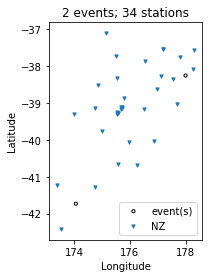

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb8024ea750>)

In [41]:
# map() uses source and receiver metadata to plot a very simple source-receiver map
insp.map()

(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb802444d10>)

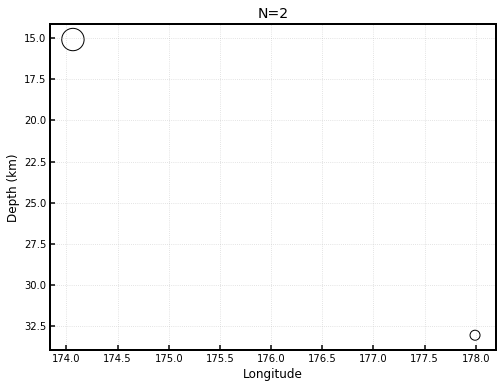

In [42]:
# event_depths() simply plots a 2D cross section of all the events at depth
insp.event_depths(xaxis="longitude")

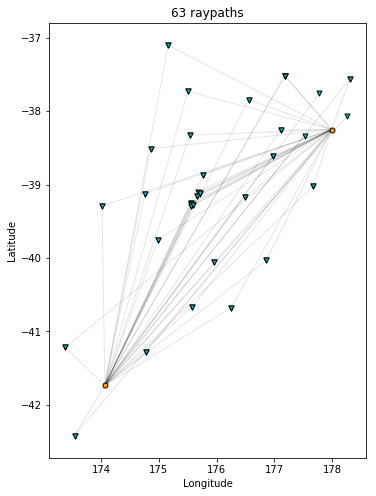

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb802382f10>)

In [43]:
# raypaths() shows source-receiver connection points for any pair that has atleast one measurement
insp.raypaths(iteration="i01", step_count="s00")

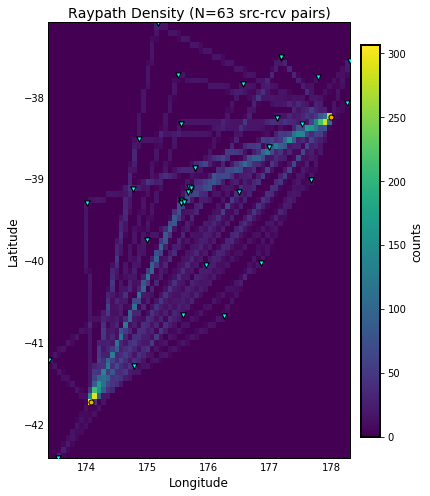

In [44]:
# raypath_density() provides a more detailed raypath plot by coloring in the density of rays. Useful 
# if you have a large number of source-receiver pairs, at which point the raypaths tend to be more difficult
# to interpret
insp.raypath_density(iteration="i01", step_count="s00")

Index(['time', 'magnitude', 'depth_km', 'latitude', 'longitude'], dtype='object')


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb7fa974c90>)

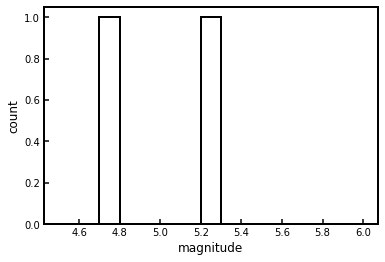

In [45]:
# event_hist() makes a simple histogram of event information based on a given source parameter
print(insp.sources.keys())
insp.event_hist(choice="magnitude")

---
### Measurement start times and window lengths

The following plotting functions are concerned with visualizing what part of the seismic waveform 
we are measuring. These include record sections and window plots.

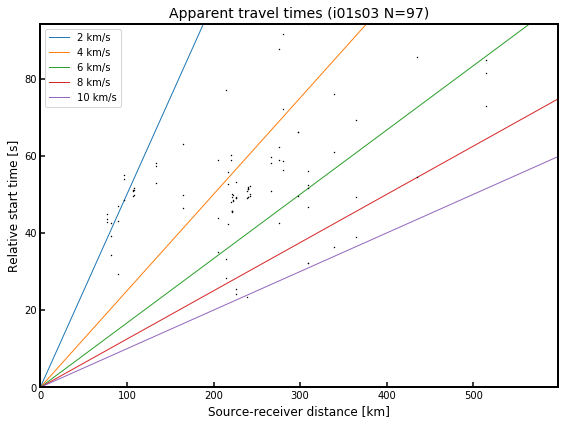

In [46]:
# travel_times() plots a proxy for phase arrivals, like a seismic record section.
# useful for inspecting potential phases of your measurements
insp.travel_times(markersize=2, t_offset=-20, constants=[2, 4, 6, 8, 10])

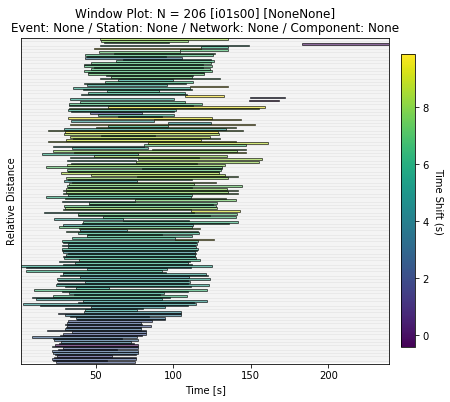

In [47]:
# plot_windows() plots the time windows against source-receiver distance to illustrate which phases are 
# included in the inversion. This was inspired by Carl Tape's PhD thesis and the LASIF plotting functionality
# showcased in Krischer et al. (2018; JGR).
insp.plot_windows(iteration="i01", step_count="s00")

---
### Inversion statistics

The following plotting functions help the user understand how an inversion is progressing by comparing iterations against one another

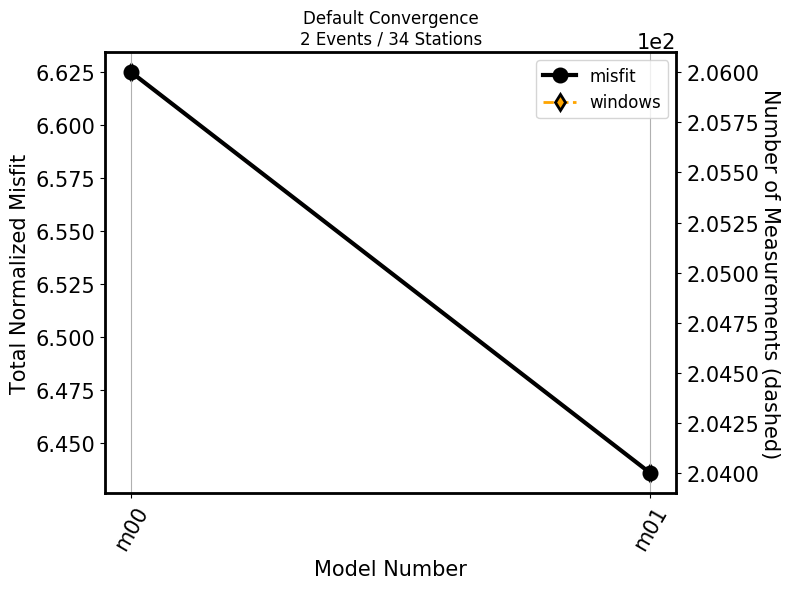

(<Figure size 800x600 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb7fa78fcd0>)

In [48]:
# convergence() shows the convergence plot, or misfit reduction over the course of the inversion
# Note: because our test data only has two iterations, its convergence plot is not very illustrative.
insp.convergence(windows="nwin")

Index(['event', 'iteration', 'step', 'network', 'station', 'channel',
       'component', 'misfit', 'length_s', 'dlnA', 'window_weight',
       'max_cc_value', 'relative_endtime', 'relative_starttime',
       'cc_shift_in_seconds', 'absolute_starttime', 'absolute_endtime'],
      dtype='object')


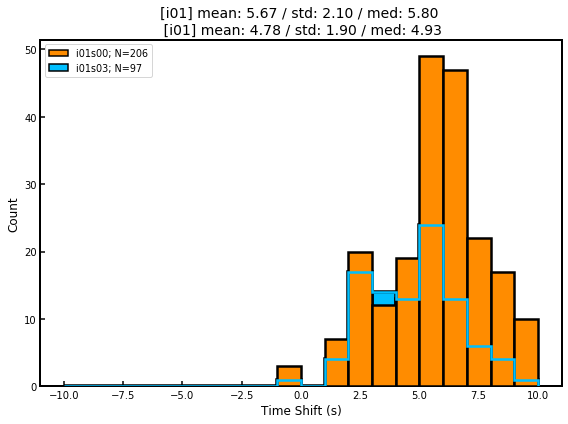

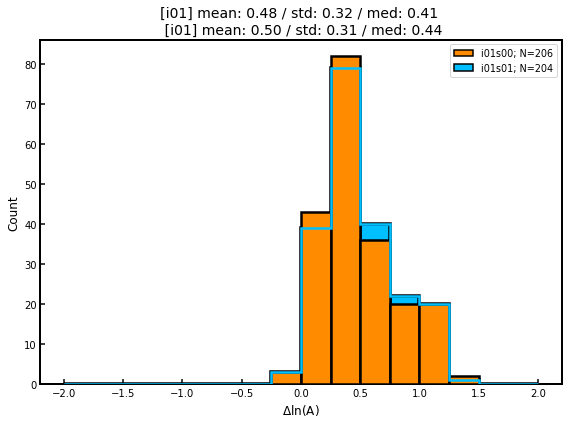

(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb7fa3b4a90>)

In [49]:
# hist() creates misfit histograms for all measurements comparing two evaluations (defaults to first and last)
# choices are available from any of the `windows` attributes
print(insp.windows.keys())
insp.hist(choice="cc_shift_in_seconds")
insp.hist(iteration="i01", step_count="s00", iteration_comp="i01", step_count_comp="s01", choice="dlnA")

---
### Measurement statistics

These plotting functions allow the user to plot measurements for a given evaluation in order to better understand the statistical distribution of measurements, or comparisons against one another.

Index(['event', 'iteration', 'step', 'network', 'station', 'channel',
       'component', 'misfit', 'length_s', 'dlnA', 'window_weight',
       'max_cc_value', 'relative_endtime', 'relative_starttime',
       'cc_shift_in_seconds', 'absolute_starttime', 'absolute_endtime'],
      dtype='object')


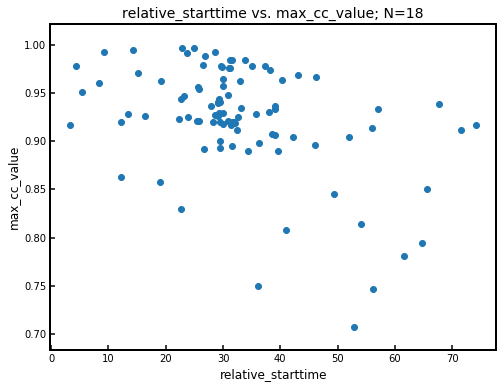

(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb7f8935790>)

In [50]:
# scatter() compares any two attributes in the `windows` dataframe
print(insp.windows.keys())
insp.scatter(x="relative_starttime", y="max_cc_value")

/home/bchow/REPOSITORIES/pyatoa/pyatoa/visuals/insp_plot.py:563: PerformanceWarning: indexing past lexsort depth may impact performance.
  level=choice).loc[iteration, step_count].nwin.to_numpy()


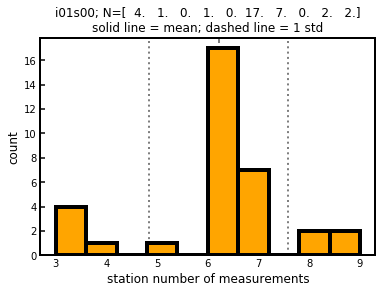

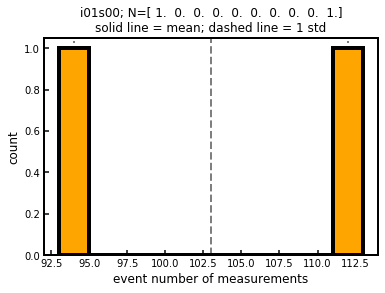

In [51]:
# measurement_hist() makes histograms of measurement numbers for 'stations' or 'event'
# Useful for identifying events or stations with outlier number of measurements
insp.measurement_hist(iteration="i01", step_count="s00", choice="station")
insp.measurement_hist(iteration="i01", step_count="s00", choice="event")

['BFZ' 'BKZ' 'ETVZ' 'FWVZ' 'HIZ' 'KHEZ' 'KHZ' 'KNZ' 'MAVZ' 'MKAZ' 'MRZ'
 'MXZ' 'NNZ' 'NTVZ' 'OPRZ' 'OTVZ' 'PXZ' 'RATZ' 'RTZ' 'TLZ' 'TMVZ' 'TOZ'
 'TRVZ' 'TSZ' 'URZ' 'VRZ' 'WAZ' 'WEL' 'WHVZ' 'WIZ' 'WSRZ' 'HAZ' 'MWZ' 'PUZ']


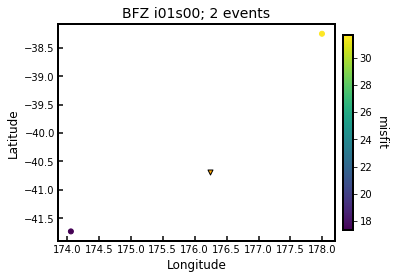

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb7f8768590>)

In [52]:
# station_event_misfit_map() creates a map for a single station. Each point that isn't the station 
# will be colored by a certain value corresponding to each event. Choices are 'nwin' or 'misfit'
print(insp.stations)
insp.station_event_misfit_map(station="BFZ", iteration="i01", step_count="s00", choice="misfit")

['2014p952799' '2013p617227']


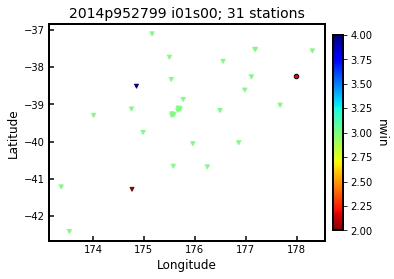

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb7f869d210>)

In [53]:
# event_station_misfit_map() creates a map for a single event. Each point that isn't the event 
# will be colored by a certain value corresponding to each station. Choices are 'nwin' or 'misfit'
print(insp.events)
insp.event_station_misfit_map(event="2014p952799", iteration="i01", step_count="s00", choice="nwin", cmap="jet_r")

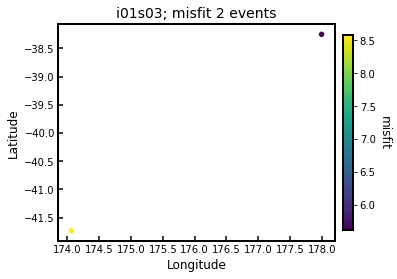

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb7f868b690>)

In [54]:
# event_misfit_map() plots all events on a map and their corresponding scaled misfit value
# for a given evaluation (defaults to last evaluation in the Inspector)
insp.event_misfit_map(choice="misfit")